# **Tecnológico de Costa Rica**
### Inteligencia Artificial - Predicción de retrasos en vuelos


## 1. Análisis del problema
El objetivo del cuaderno es construir un modelo que estime el retraso en la llegada (`ArrDelay`) de vuelos comerciales a partir de información histórica de itinerarios. Nos interesa predecir la magnitud del retraso para anticipar afectaciones operativas en aerolíneas y aeropuertos. El problema se aborda como una tarea de regresión supervisada, donde se comparan las salidas del modelo con los retrasos reales para medir desempeño.


In [ ]:
import pandas as pd


df = pd.read_csv("DelayedFlights.csv")
df

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1.0,3.0,4.0,2003.0,1955.0,2211.0,2225.0,WN,...,4.0,8.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1.0,3.0,4.0,754.0,735.0,1002.0,1000.0,WN,...,5.0,10.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1.0,3.0,4.0,628.0,620.0,804.0,750.0,WN,...,3.0,17.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1.0,3.0,4.0,1829.0,1755.0,1959.0,1925.0,WN,...,3.0,10.0,0.0,N,0.0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1.0,3.0,4.0,1940.0,1915.0,2121.0,2110.0,WN,...,4.0,10.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518091,1623434,2008,3.0,17.0,1.0,1745.0,1731.0,2102.0,2030.0,NW,...,3.0,18.0,0.0,N,0.0,0.0,0.0,18.0,0.0,14.0
518092,1623439,2008,3.0,22.0,6.0,1849.0,1731.0,2140.0,2030.0,NW,...,8.0,29.0,0.0,N,0.0,0.0,0.0,0.0,0.0,70.0
518093,1623440,2008,3.0,23.0,7.0,1817.0,1731.0,2124.0,2030.0,NW,...,6.0,48.0,0.0,N,0.0,0.0,0.0,8.0,0.0,46.0
518094,1623445,2008,3.0,28.0,5.0,1823.0,1731.0,2112.0,2030.0,NW,...,6.0,15.0,0.0,N,0.0,42.0,0.0,0.0,0.0,0.0


## 2. Entendimiento de los datos
Trabajamos con el conjunto `DelayedFlights.csv`, el cual contiene registros de vuelos de EE. UU. con información temporal, de aerolínea, origen/destino y banderas de cancelaciones o desvíos. Las variables numéricas (por ejemplo `DepTime`, `Distance`) coexisten con identificadores categóricos (`UniqueCarrier`, `Origin`, `Dest`). La variable objetivo es `ArrDelay`, que expresa minutos de retraso en la llegada; los valores nulos en esta columna impiden evaluar el rendimiento y por ello se tratan antes de modelar.


In [ ]:
# Eliminar filas canceladas/divertidas
df = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]

# Eliminar nulos en la variable objetivo
df = df.dropna(subset=['ArrDelay'])

# Reemplazar nulos en otras columnas por 0
df = df.fillna(0)

## 3. Exploración de los datos
Previo al modelado se realiza una depuración básica: se eliminan vuelos cancelados (`Cancelled == 1`) o desviados (`Diverted == 1`) porque no aportan información fiable sobre retrasos en la llegada. También se gestionan los valores faltantes; primero se descartan los registros sin `ArrDelay` y luego se rellenan con cero las columnas restantes para preservar el mayor número posible de observaciones. Esta limpieza deja el dataset listo para seleccionar variables y continuar con la ingeniería de características.


In [ ]:
features = [
    'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
    'CRSArrTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'DepDelay'
]
target = 'ArrDelay'

X = df[features].copy()
y = df[target]

## 4. Modelo
La configuración del modelo utiliza un subconjunto de atributos que describen calendario (`Month`, `DayofMonth`, `DayOfWeek`), horarios (`DepTime`, `CRSDepTime`, `CRSArrTime`), identificadores de aerolíneas y aeropuertos (`UniqueCarrier`, `Origin`, `Dest`), y variables operativas (`Distance`, `DepDelay`). Para convertir las variables categóricas se aplica `LabelEncoder`, transformando `UniqueCarrier`, `Origin` y `Dest` en índices numéricos que pueden interpretar los algoritmos basados en árboles. Posteriormente, los datos se dividen en entrenamiento y prueba con una partición 80/20 (semilla 42) para evaluar la capacidad de generalización del modelo. El estimador seleccionado es un `RandomForestRegressor` con 200 árboles, profundidad máxima de 20 y ejecución paralela (`n_jobs=-1`), lo que equilibra capacidad predictiva y control del sobreajuste.


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_cols = ['UniqueCarrier', 'Origin', 'Dest']
le = LabelEncoder()
for col in label_cols:
    X[col] = le.fit_transform(X[col])

> La codificación de etiquetas se ajusta únicamente con las columnas categóricas necesarias y se reutiliza para transformaciones posteriores, facilitando la integración del modelo en producción.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

> La partición estratificada no es necesaria porque la variable objetivo es continua; sin embargo, se fija `random_state=42` para garantizar reproducibilidad en la comparación de resultados.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

## 5. Evaluación
Con el conjunto de prueba se calculan métricas estándar de regresión: error absoluto medio (MAE) para interpretar el retraso promedio en minutos, raíz del error cuadrático medio (RMSE) para penalizar errores grandes y el coeficiente de determinación (R²) para cuantificar la varianza explicada. Además, se analiza la importancia de las variables del bosque aleatorio, lo que permite identificar qué factores influyen más en la predicción del retraso y orientar mejoras futuras.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


MAE: 10.89
RMSE: 16.11
R²: 0.914


> La visualización de importancia de características apoya la toma de decisiones al resaltar, por ejemplo, el peso de `DepDelay` y los horarios programados en el tiempo de llegada.



Importancia de variables:
DepDelay         0.935975
Distance         0.010867
CRSArrTime       0.009162
DayofMonth       0.007926
Origin           0.007085
Dest             0.006874
DepTime          0.006196
CRSDepTime       0.004939
UniqueCarrier    0.004673
DayOfWeek        0.004199
Month            0.002101
dtype: float64


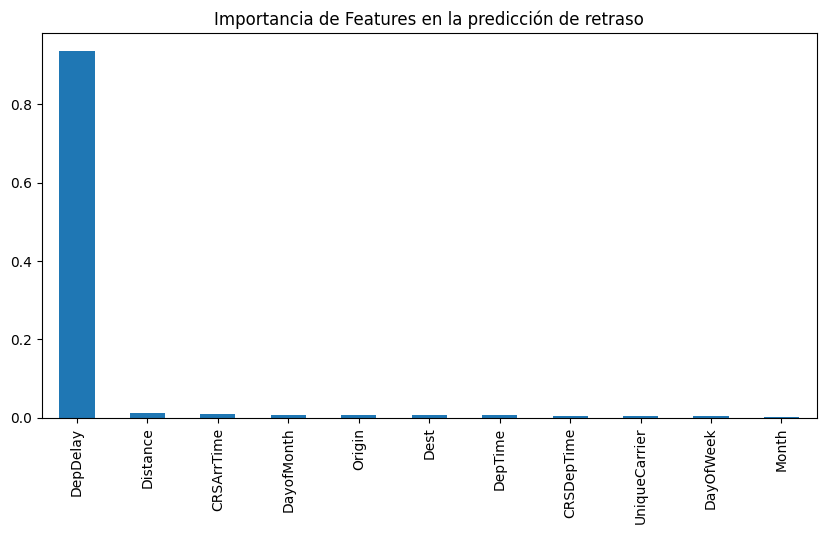

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportancia de variables:")
print(importances)
plt.figure(figsize=(10,5))
importances.plot(kind='bar')
plt.title("Importancia de Features en la predicción de retraso")
plt.show()

## 6. Conclusión
El flujo completa la preparación, entrenamiento y validación de un modelo de retrasos, y serializa el resultado con `joblib` junto con metadatos (columnas usadas, codificadores y métricas). Esto habilita el despliegue en la API del backend y facilita auditorías futuras. Como líneas de trabajo adicionales se sugiere incorporar variables externas (clima, saturación aeroportuaria), probar métodos avanzados de imputación y comparar con otros algoritmos para mejorar la precisión del pronóstico.


In [ ]:
import joblib
from datetime import datetime
import os

version = 1
date_str = datetime.now().strftime("%Y-%m-%d")

model_data = {
    'model': model,
    'feature_columns': X.columns.tolist(),
    'label_encoders': le,
    'training_info': {
        'mae': mae,
        'rmse': rmse,
        'r2_score': r2,
        'train_size': len(X_train),
        'test_size': len(X_test)
    }
}

model_filename = f"flight_delay_v{version}_{date_str}.pkl"
joblib.dump(model_data, model_filename)

['flight_delay_v1_2025-10-25.pkl']